# Preparing the Intermediate Scattering Function for Maximum Entropy

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import pi as π
from scipy.constants import hbar as ħ
from scipy.constants import k as kb

from include.pimchelp import PIMCResults
import include.helium as helium
#import include.colors as colortools

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.style.use('include/notebook.mplstyle')
cols = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Paramters

In [4]:
T = 1.2 #K
ρ =  0.021858 # 1/Å^3
N = 64
τ = 0.0104 # (1/K)
L = (N/ρ)**(1/3)
M = int(1.0/(T*τ))

## Process and Load Results

In [6]:
%run /Users/agdelma/Documents/UVM/Projects/SCRIPTS/merge.py --canonical -T 1.2 -N 64 -n 0.022 -t 0.01040 ../../Data/ISF/
%run /Users/agdelma/Documents/UVM/Projects/SCRIPTS/reduce-one.py  --canonical -r T -N 64 -n 0.022 -t 0.01040 -e isf ../../Data/ISF/MERGED/

Merged data files:
ce-isf-01.200-0064-00.022-0.01040-ced6cffd-fe12-462b-ac27-23961b6330b5.dat            3000


In [6]:
isf = PIMCResults('../../../Data/ISF/MERGED/isf-T-reduce-N-0064-n-00.022-t-0.01040.dat')
q = isf.qvals
print(q)

[0.7607068 1.756777  1.810844 ]


## Intermediate Scattering Function

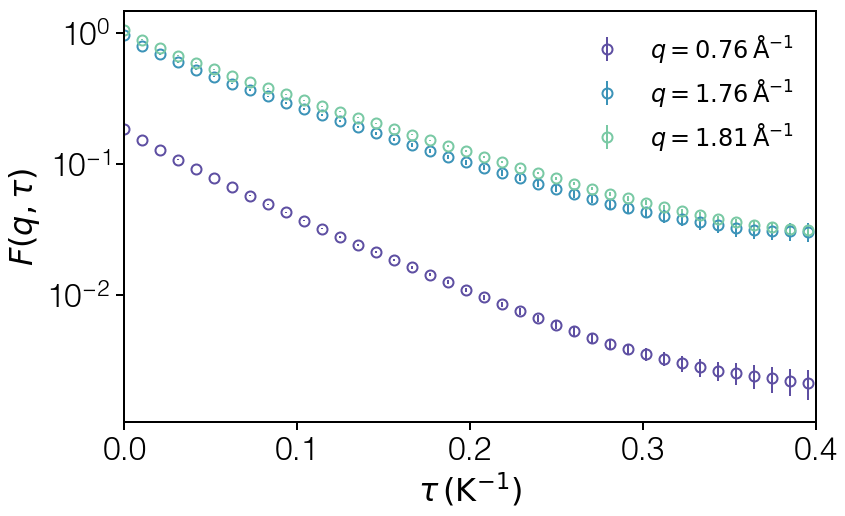

In [7]:
ax = plt.subplot(111)
for i,qparam in enumerate(isf.qparams):
    for param in isf.params:
        ax.errorbar(*isf.epdata(qparam,param), mec=cols[i], marker='o',ms=5, ls='None', 
                 elinewidth=1,mfc='None',ecolor=cols[i],label=r'$q ={:5.2f}\, {{\rm \AA}}^{{-1}}$'.format(q[i]))

ax.set_yscale("log", nonposy='clip')
ax.legend(fontsize=12, frameon=False)
ax.set_ylabel(r'$F(q,\tau)$')
plt.xlabel(r'$\tau\, (\rm K^{-1})$');
plt.xlim(0,0.4);

## Moments

In [9]:
from collections import defaultdict
moments = defaultdict(list)
for i,qparam in enumerate(isf.qparams):
    moments[qparam].append(isf.y(qparam,isf.params[0])[0])
    moments[qparam].append(ħ**2*(q[i]**2)*1E20/(2.0*helium.const['mass'])/kb)

In [10]:
moments

defaultdict(list,
            {'q = 7.607068E-01': [0.184549875, 3.5065683583332157],
             'q = 1.756777E+00': [0.96487145, 18.701695717773166],
             'q = 1.810844E+00': [1.0659777, 19.8705454912562]})

## Save to disk

In [11]:
for i,qparam in enumerate(isf.qparams):
    odata = np.array(isf.epdata(qparam,isf.params[0])).T
    np.savetxt('../Output/Gtau_{:4.2f}.dat'.format(q[i]),odata,delimiter='\t')
! cp ../Output/Gtau_*.dat ../../MaxEnt/OmegaMaxEnt_source_2018-01/Boronat/

## Load Our MaxEnt Results

In [12]:
Sqw_maxent = {}
Sqw_maxent[isf.qparams[0]] = np.loadtxt('../../MaxEnt/OmegaMaxEnt_source_2018-01/Boronat/OmegaMaxEnt_final_result/optimal_spectral_function_tem1.2_alpha2.73e+00.dat')
Sqw_maxent[isf.qparams[0]][:,1] *= Sqw_maxent[isf.qparams[0]][:,0]
Sqw_maxent[isf.qparams[-1]] = np.loadtxt('../../MaxEnt/OmegaMaxEnt_source_2018-01/Boronat/OmegaMaxEnt_final_result/optimal_spectral_function_tem1.2_alpha8.66e-01.dat')
Sqw_maxent[isf.qparams[-1]][:,1] *= Sqw_maxent[isf.qparams[-1]][:,0]

## Determine Normalization based on 0th moment

In [13]:
from scipy import integrate
norm = {}

for qparam in isf.qparams:
    try:
        norm[qparam] = 2*integrate.trapz(Sqw_maxent[qparam][:,1],Sqw_maxent[qparam][:,0])/moments[qparam][0]
    except:
        pass
print(norm)

{'q = 7.607068E-01': 32.5381744183023, 'q = 1.810844E+00': 6.282237008914435}


## Load Boronat S(q,w) from disk

In [14]:
bq = [isf.qparams[0],isf.qparams[-1]]
b_maxent = {}
b_gift = {}
b_gift_norm = {}
for qparam in bq:
    b_maxent[qparam] = np.loadtxt('../Data/Sqw_{:4.2f}_MaxEnt.dat'.format(q[i]))
    b_gift[qparam] = np.loadtxt('../Data/Sqw_{:4.2f}_GIFT.dat'.format(q[i]))

    # check normalization
    b_gift_norm[qparam] = 2*integrate.trapz(b_gift[qparam][:,1],b_gift[qparam][:,0])/moments[qparam][0]
    
print(b_gift_norm)

{'q = 7.607068E-01': 11.097377592144129, 'q = 1.810844E+00': 1.921259372928721}


## Load Experimental Data from Disk

In [15]:
exp_data = {isf.qparams[-1]:np.loadtxt('../Data/exp_Sw_q_1.8_T_1.1.dat'), 
            isf.qparams[0]:np.loadtxt('../Data/exp_Sw_q_0.71_T_1.1.dat')}

exp_norm = {}
for qparam in bq:
    exp_norm[qparam] = 2*integrate.trapz(exp_data[qparam][:,1],exp_data[qparam][:,0])/moments[qparam][0]
    exp_data[qparam][:,1] /= exp_norm[qparam]

## Load Nathan's GIFT Data for Q = 0.76

In [16]:
gift = {'0.76':np.loadtxt('../Data/gift-0.76.dat')}

print(integrate.trapz(gift['0.76'][:,0],gift['0.76'][:,1]))
print(integrate.trapz(gift['0.76'][:,1]*gift['0.76'][:,0],gift['0.76'][:,1]))

print(2*integrate.trapz(Sqw_maxent['0.76'][:,1]/norm['0.76'],Sqw_maxent['0.76'][:,0]))
print(2*integrate.trapz(Sqw_maxent['0.76'][:,0]*Sqw_maxent['0.76'][:,1]/norm['0.76'],Sqw_maxent['0.76'][:,0]))

0.184762989809423
3.1847232261692


KeyError: '0.76'

## Compare Results

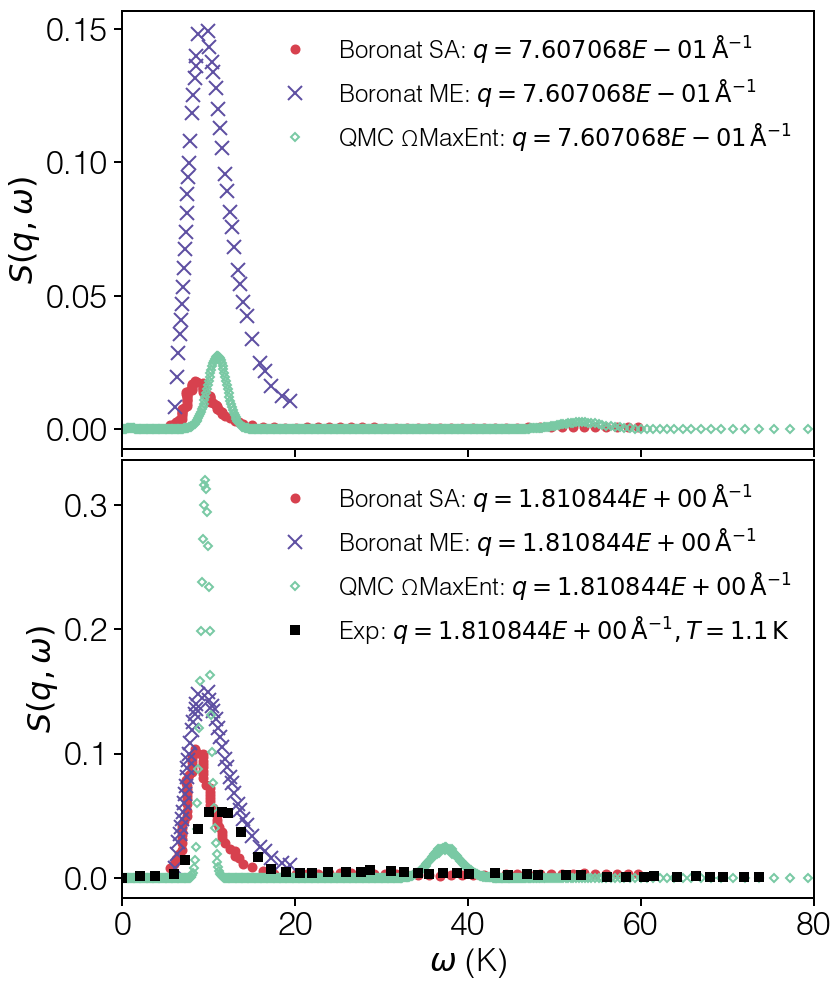

In [18]:
fig, ax = plt.subplots(2,1, sharex=True, figsize=(6,8), squeeze=True)
fig.subplots_adjust(hspace=0.025)

for i,qparam in enumerate(bq):
    ax[i].plot(b_gift[qparam][:,0],b_gift[qparam][:,1]/b_gift_norm[qparam],'.', color=cols[8], mew=1, mfc=cols[8],
            label=r'Boronat SA: ${:s}\, {{\rm \AA}}^{{-1}}$'.format(qparam))
    ax[i].plot(b_maxent[qparam][:,0],b_maxent[qparam][:,1],'x', color=cols[0], mew=1, mfc='None', ms=7,
            label=r'Boronat ME: ${:s}\, {{\rm \AA}}^{{-1}}$'.format(qparam))
        
    idx = 1
    ax[i].plot(Sqw_maxent[qparam][:,0],Sqw_maxent[qparam][:,idx]/norm[qparam],'D', color=cols[2], mew=1, 
               mfc='None', ms=3, label=r'QMC ΩMaxEnt: ${:s}\, {{\rm \AA}}^{{-1}}$'.format(qparam))

    if i == 1:
        ax[i].plot(exp_data[qparam][:,0],exp_data[qparam][:,1],'s', color='k', mew=0, mfc='k', ms=5,
             label=r'Exp: ${:s}\, {{\rm \AA}}^{{-1}}, T = 1.1\,{{\rm K}}$'.format(qparam))
        
 #   if i == 0:
 #       ax[i].plot(gift[key][:,1],gift[key][:,0]/2,'+', color=cols[-3], mew=0.5, mfc='None', ms=5,
 #            label=r'GIFT: $q ={:5.2f}\, {{\rm \AA}}^{{-1}}$'.format(cq), ls='None', lw=0.5)
        
    ax[i].legend(fontsize=12, frameon=False)
    ax[i].set_xlim(0,80)    
    ax[i].set_ylabel(r'$S(q,\omega)$')
ax[1].set_xlabel(r'$\omega$ (K)');
plt.savefig('../Output/Sqw_boronat_comparison.png', dpi=300, transparent=False)

## The Covariance Matrix

In [67]:
Gt = np.loadtxt('../../../Data/ISF/MERGED/ce-isfq1.810844E+00-01.200-0064-00.022-0.01040-307308770.dat')

In [68]:
# normalize data
Nbins = Gt.shape[0]
#M = Gt.shape[1]
#for n in range(Nbins):
#    Gt[n,:] /= Gt[n,0]

In [69]:
# compute averages
from scipy import stats
τvals = np.linspace(0,1/T,81)
Gave = np.average(Gt,axis=0)
Gerr = stats.sem(Gt)
C = np.cov(Gt[:,:].T)/Nbins

## A binning analysis

In [70]:
def get_binned_error(mc_data):
    '''Get the standard error in mc_data and return neighbor averaged data.'''
    N_bins = mc_data.shape[0]
    Δ = np.std(mc_data,axis=0)/np.sqrt(N_bins)
    
    start_bin = N_bins % 2
    binned_mc_data = 0.5*(mc_data[start_bin::2]+mc_data[start_bin+1::2])
   
    return Δ,binned_mc_data

def binning_error(mc_data):
    '''Perform a binning analysis'''
    
    from scipy.signal import find_peaks
    
    # number of possible binning levels
    num_levels = np.int(np.log2(mc_data.shape[0]/4))+1

    # compute the error at each bin level
    Δ = []
    num_bins = []
    binned_mc_data = mc_data
    
    binned_error = np.zeros_like(mc_data[0,:])

    for n in range(num_levels):
        Δₙ,binned_mc_data = get_binned_error(binned_mc_data)
        Δ.append(Δₙ)
        num_bins.append(2**n) 
        
    Δ = np.array(Δ)
    
    # find the maxima which corresponds to the error
    for i in range(mc_data.shape[1]):
        plateau = find_peaks(Δ[:,i])[0]
        if plateau.size > 0:
            binned_error[i] = Δ[plateau[0],i]
        else:
            binned_error[i] = np.max(Δ[:,i])
            print('Binning Converge Error: no plateau found')
            
    return np.array(num_bins),Δ,binned_error

In [71]:
num_bins,Δ,err = binning_error(Gt)

Binning Converge Error: no plateau found
Binning Converge Error: no plateau found
Binning Converge Error: no plateau found
Binning Converge Error: no plateau found
Binning Converge Error: no plateau found
Binning Converge Error: no plateau found
Binning Converge Error: no plateau found
Binning Converge Error: no plateau found
Binning Converge Error: no plateau found
Binning Converge Error: no plateau found
Binning Converge Error: no plateau found
Binning Converge Error: no plateau found
Binning Converge Error: no plateau found
Binning Converge Error: no plateau found
Binning Converge Error: no plateau found
Binning Converge Error: no plateau found
Binning Converge Error: no plateau found
Binning Converge Error: no plateau found
Binning Converge Error: no plateau found
Binning Converge Error: no plateau found
Binning Converge Error: no plateau found
Binning Converge Error: no plateau found
Binning Converge Error: no plateau found
Binning Converge Error: no plateau found
Binning Converge

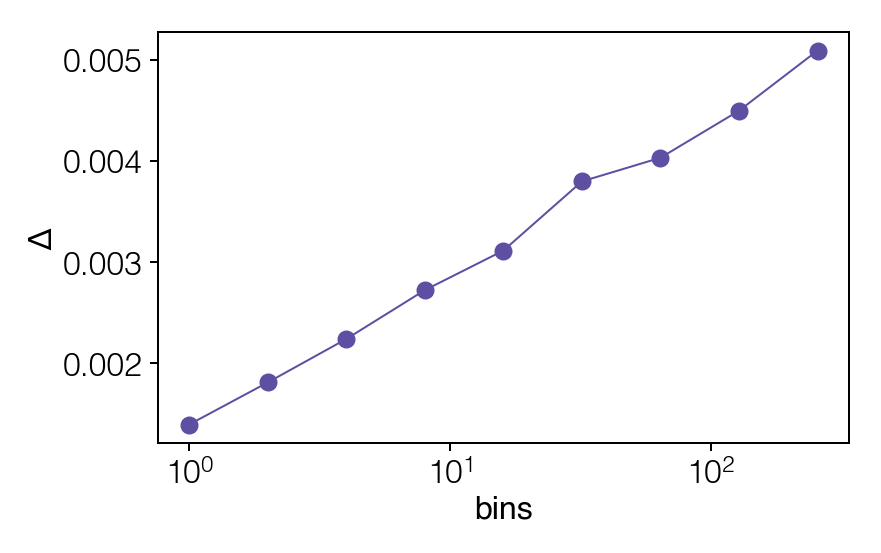

In [72]:
plt.semilogx(num_bins,Δ[:,13],'-o', linewidth=1, markersize=8)

plt.xlabel('bins')
plt.ylabel('Δ');

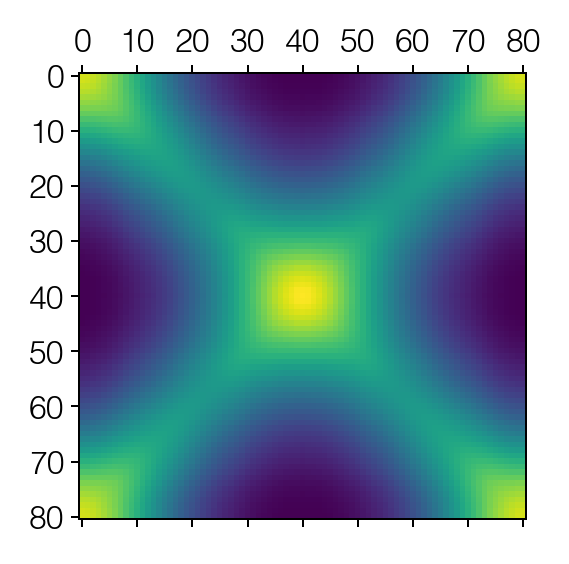

In [73]:
plt.matshow(C)

In [75]:
np.savetxt('../MaxEnt/OmegaMaxEnt_source_2018-01/Boronat/Gtau_1.81.dat',np.vstack((τvals,Gave,err)).T,delimiter='\t')
#np.savetxt('Output/CGtau_1.81.dat',C,delimiter='\t')

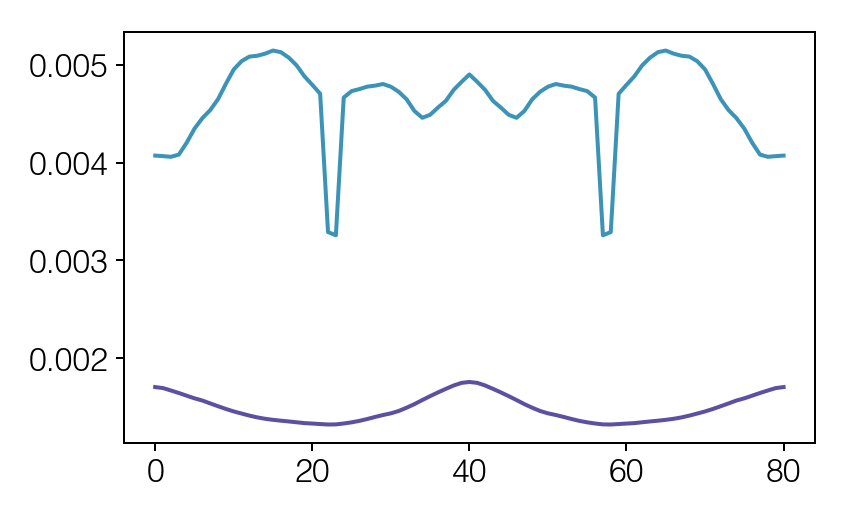

In [74]:
plt.plot(Gerr)
plt.plot(err)

In [440]:
from scipy.linalg import eig,inv

In [441]:
e,V = eig(C)

In [456]:
np.where(np.abs(e)<1E-16)[0]

array([41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57,
       58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74,
       75, 76, 77, 78, 79, 80])

In [414]:
e1,V1 = eig(tC)

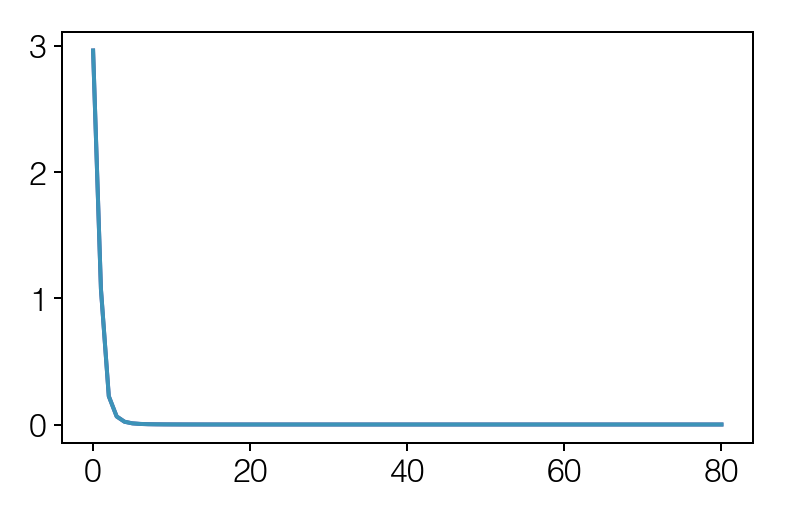

In [417]:
plt.plot(e.real)
plt.plot(e1.real)

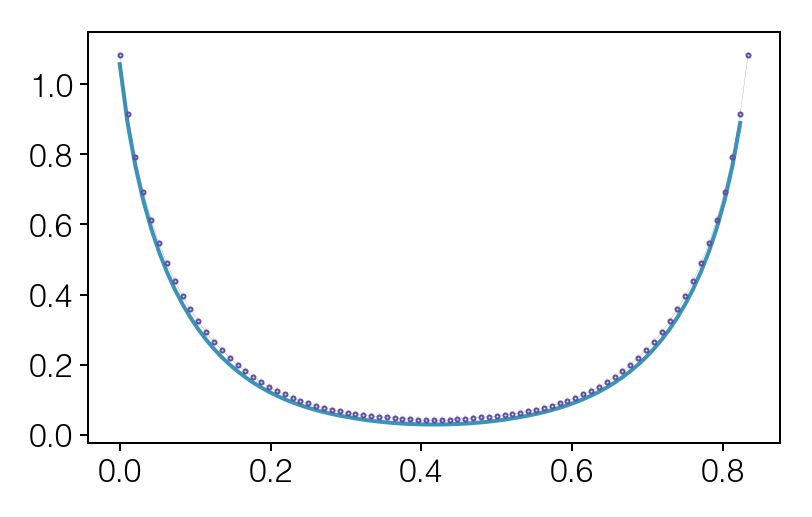

In [607]:
plt.errorbar(τvals,Gave,yerr=err,marker='o', mfc='None', ms=2, linewidth=0.1)
plt.plot(isf[key][:,0],isf[key][:,1])

In [585]:
np.min(Gave)

0.03232187924222222

In [290]:
tC = np.zeros([81,81])
Gave = np.average(Gt,axis=0)

for i in range(81):
    for j in range(81):
        for n in range(Nbins):
            tC[i,j] += (Gt[n,i]-Gave[i])*(Gt[n,j]-Gave[j])

In [ ]:
#avg, w_sum = average(X, axis=1, weights=w, returned=True)

#X -= avg[:, None]
#if w is None:
#    X_T = X.T
#else:
#    X_T = (X*w).T
#c = dot(X, X_T.conj())
#c *= np.true_divide(1, fact)
#return c.squeeze()

In [620]:
moments = defaultdict(np.zeros([10,10]))

TypeError: first argument must be callable or None

In [623]:
a = ['1.2','3.4']
c = np.array([float(ca) for ca in a])

In [624]:
c

array([1.2, 3.4])

In [625]:
c = np.append(c,1.3)

In [39]:
1/8.333333699999999622e-01

1.1999999472000025

In [25]:
qp = 'q = 7.607068E-01'   
p1 = 'T = 1.20'
p2 = 'N = 24'

In [37]:
def gkey(par):
    val = par.split('=')[-1]
    
    width = len(val)
    
    # check if we have scientific notation
    if 'e' in val or 'E' in val:
        sformat = 'E'
        prec = len(val.split('.')[-1][:-4])
    elif '.' in val:
        prec = len(val.split('.')[-1])
        sformat = 'f'
    else:
        
        
    return prec

In [39]:
print(gkey(p1))

2


In [46]:
print('π = {:{sign}{width}.{precision}{sformat}}'.format(+π,width=4,sign=' ',precision=4,sformat='E'))

π =  3.1416E+00


In [50]:
print('{:9d}'.format(11))

       11


In [113]:
import pimchelp
import importlib
importlib.reload(pimchelp)
PimcResults = pimchelp.PimcResults

In [110]:
isf = PimcResults('../../Data/ISF/MERGED/isf-T-reduce-N-0064-n-00.022-t-0.01040.dat')


7.607068E-01
1.20


In [102]:
isf.headers

['τ [1/K]', 'F(q,τ)', 'ΔF(q,τ)']

In [107]:
isf.pprecision

2

In [104]:
isf.params

['T = 1.20']